# Regression

## Generate data set

In this example, we will solve a regression task with uncertainty estimation using Conditional Normalizing Flows. In addition, we will compare this approach with the Gaussian Process. Let’s generate a data set with observations sampled from a normal distribution, where mean and variance depend on input variable X.

In [1]:
# import of basic libraries
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from sklearn.datasets import make_moons
import numpy as np
import torch


In [2]:
# function we would like to predict
def func(X):
    return np.exp(-X)

In [91]:
# input variable
X_moon, y_moon = make_moons(n_samples=500)
X_moon = np.array(X_moon)
X = np.linspace(0, 5, 500).reshape(-1, 1)

# mean values of targets y
mu = func(X)

# normal noise
eps = np.random.normal(0, 1, X.shape)
sigma = 0.05*(X+0.5)

# target variable we need to predict
y = mu + eps * sigma

In [92]:
X_moon, y_moon = X_moon[:, 0][:, np.newaxis], X_moon[:, 1][:, np.newaxis]

In [93]:
X_moon.shape

(500, 1)

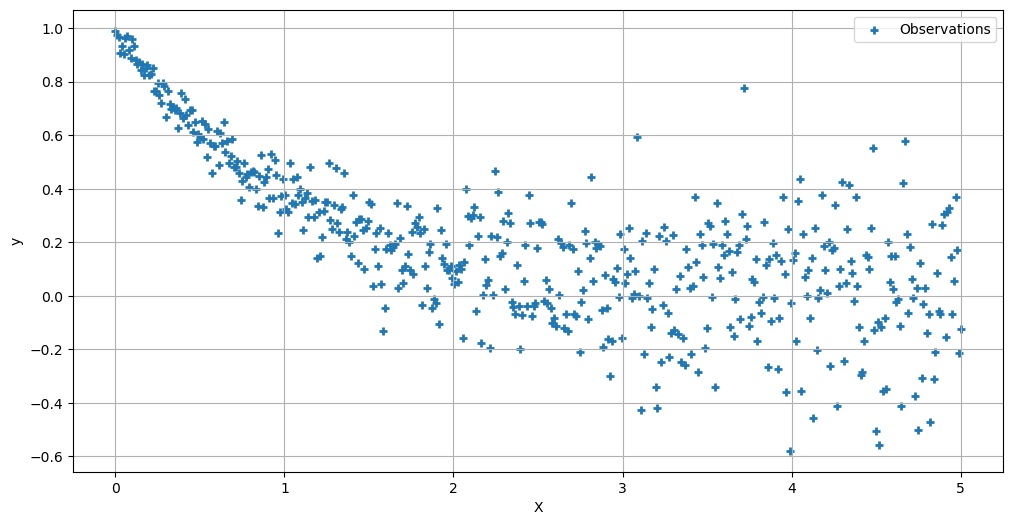

In [94]:
plt.figure(figsize=(12, 6))
# plt.plot(X, mu, label='Mean true', color='0', linewidth=2)
plt.scatter(X, y, marker='+', label='Observations', linewidth=2)

# plt.plot(X, mu+sigma, label=r'$\mu \pm \sigma$ True', color='0', linewidth=2, linestyle='--')
# plt.plot(X, mu-sigma, color='0', linewidth=2, linestyle='--')

plt.xlabel("X")
plt.ylabel("y")
plt.grid()
plt.legend()
plt.show()

## Normalizing flows

In [149]:
%%time
from realnvp import RealNVP

# fit nomalizing flow model
model = RealNVP(lr=0.01, n_epochs=500, hidden=10, kernelized=True, n_layers=8)
model.fit(y, X) # (target, condition)
print('ok')
# sample new observations
y_gen = model.sample(X)

ok
CPU times: user 770 ms, sys: 66 ms, total: 836 ms
Wall time: 802 ms


In [150]:
sum(p.numel() for p in model.nf.parameters())

320

In [151]:
- model.nf.log_prob(torch.from_numpy(X).float(), torch.from_numpy(y).float())

tensor(611.8456, grad_fn=<NegBackward0>)

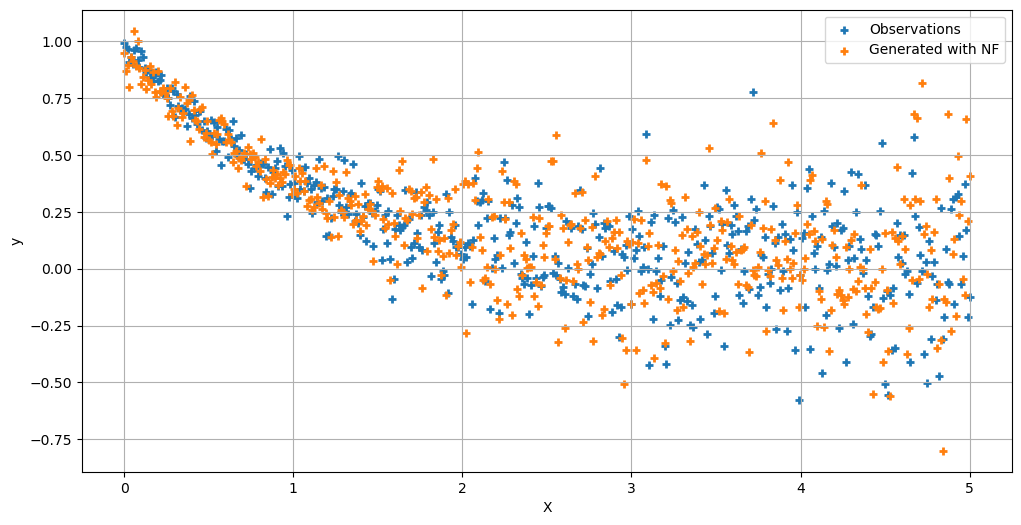

In [152]:
plt.figure(figsize=(12, 6))
# plt.plot(X, mu, label='Mean true', color='0', linewidth=2)
plt.scatter(X, y, marker='+', label='Observations', linewidth=2)
plt.scatter(X, y_gen, marker='+', label='Generated with NF', color='C1', linewidth=2)
plt.xlabel("X")
plt.ylabel("y")
plt.grid()
plt.legend()
plt.show()

In [153]:
y_preds = []

# repeat sampling several times
for i in range(1000):
    
    # sample with NF
    y_gen = model.sample(X)
    y_preds.append(y_gen)

y_preds = np.array(y_preds)

In [154]:
# estimate the mean of the predictions
mu_pred = y_preds.mean(axis=0).reshape(-1,)

# estimate the standard deviation of the predictions
sigma_pred = y_preds.std(axis=0).reshape(-1,)

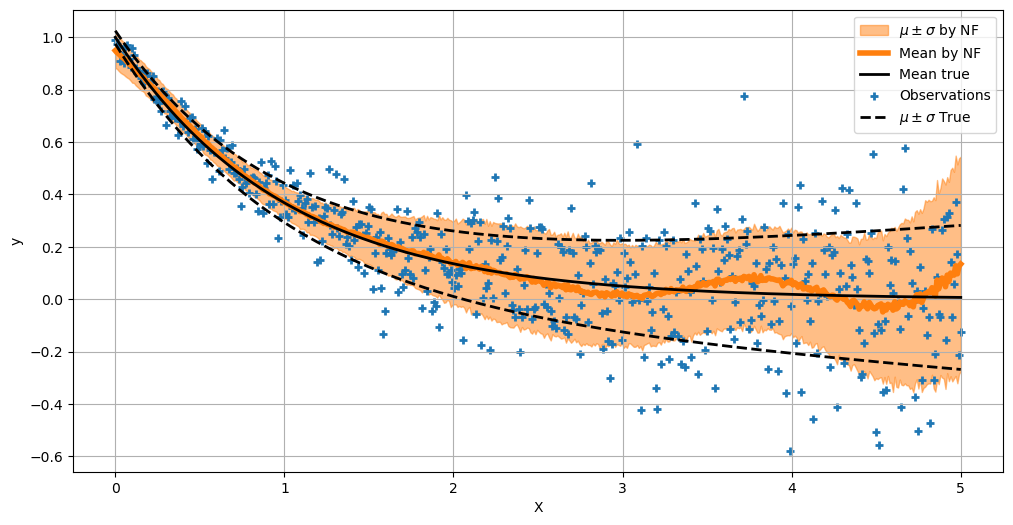

In [155]:
plt.figure(figsize=(12, 6))

plt.fill_between(X[:, 0], 
                 y1=mu_pred+sigma_pred, 
                 y2=mu_pred-sigma_pred, color='C1', alpha=0.5, label=r'$\mu \pm \sigma$ by NF')
plt.plot(X, mu_pred, label='Mean by NF', color='C1', linewidth=4)

plt.plot(X, mu, label='Mean true', color='0', linewidth=2)
plt.scatter(X, y, marker='+', label='Observations', color='C0', linewidth=2)

plt.plot(X, mu+sigma, label=r'$\mu \pm \sigma$ True', color='0', linewidth=2, linestyle='--')
plt.plot(X, mu-sigma, color='0', linewidth=2, linestyle='--')

plt.xlabel("X")
plt.ylabel("y")
plt.grid()
plt.legend()
plt.show()

## Gaussian Process

Finally, let’s solve the same task with the Gaussian Process (GP) to compare the results. The plot below shows that GP predicts the mean with good precision. However, it is not able to learn the dependency of the standard deviation from the input variable X.

In [156]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF, ConstantKernel as C

# define kernel
kernel = C() * RBF() + WhiteKernel()

# fit GP
gpr = GaussianProcessRegressor(kernel=kernel)
gpr.fit(X, y)

# make predictions of the means and standard deviations
mu_pred_gp,sigma_pred_gp  = gpr.predict(X, return_std=True)

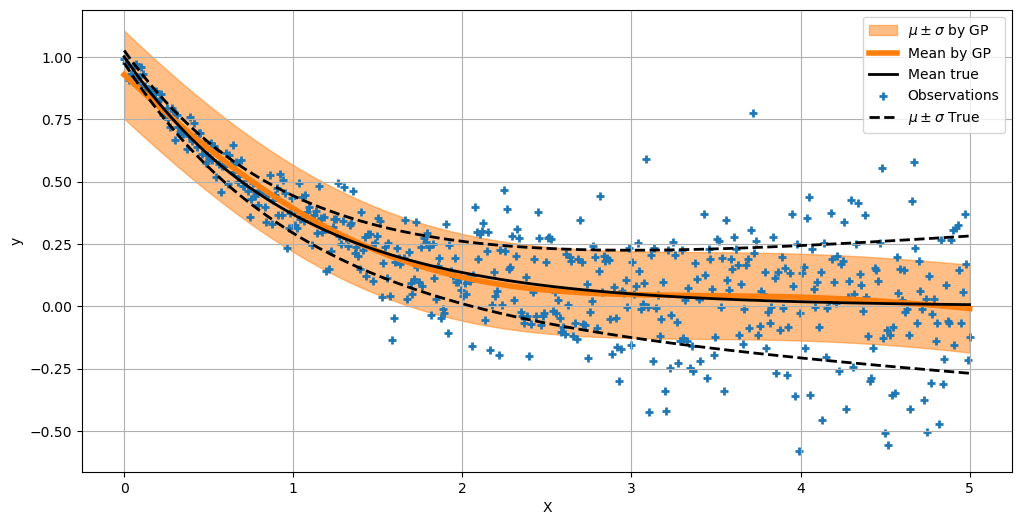

In [157]:
plt.figure(figsize=(12, 6))

plt.fill_between(X[:, 0], 
                 y1=mu_pred_gp+sigma_pred_gp, 
                 y2=mu_pred_gp-sigma_pred_gp, color='C1', alpha=0.5, label=r'$\mu \pm \sigma$ by GP')
plt.plot(X, mu_pred_gp, label='Mean by GP', color='C1', linewidth=4)

plt.plot(X, mu, label='Mean true', color='0', linewidth=2)
plt.scatter(X, y, marker='+', label='Observations', color='C0', linewidth=2)

plt.plot(X, mu+sigma, label=r'$\mu \pm \sigma$ True', color='0', linewidth=2, linestyle='--')
plt.plot(X, mu-sigma, color='0', linewidth=2, linestyle='--')

plt.xlabel("X")
plt.ylabel("y")
plt.grid()
plt.legend()
plt.show()

### Moons

In [180]:
%%time
from realnvp import RealNVP

# fit nomalizing flow model
model = RealNVP(lr=0.01, n_epochs=500, hidden=10, kernelized=True, n_layers=8)
model.fit(y_moon, X_moon) # (target, condition)
print('ok')
# sample new observations
y_gen = model.sample(X_moon)

ok
CPU times: user 773 ms, sys: 71.1 ms, total: 844 ms
Wall time: 832 ms


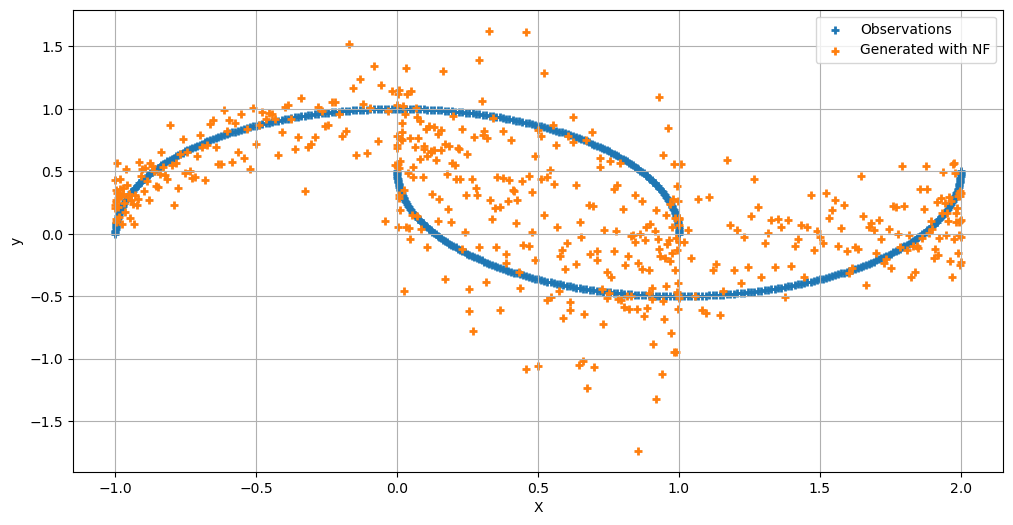

In [181]:
plt.figure(figsize=(12, 6))
# plt.plot(X, mu, label='Mean true', color='0', linewidth=2)
plt.scatter(X_moon, y_moon, marker='+', label='Observations', linewidth=2)
plt.scatter(X_moon, y_gen, marker='+', label='Generated with NF', color='C1', linewidth=2)
plt.xlabel("X")
plt.ylabel("y")
plt.grid()
plt.legend()
plt.show()

In [182]:
%%time
from realnvp import RealNVP

# fit nomalizing flow model
model = RealNVP(lr=0.01, n_epochs=500, hidden=(10,), kernelized=False, n_layers=8)
model.fit(y_moon, X_moon) # (target, condition)
print('ok')
# sample new observations
y_gen = model.sample(X_moon)

ok
CPU times: user 16.9 s, sys: 59.5 ms, total: 16.9 s
Wall time: 17 s


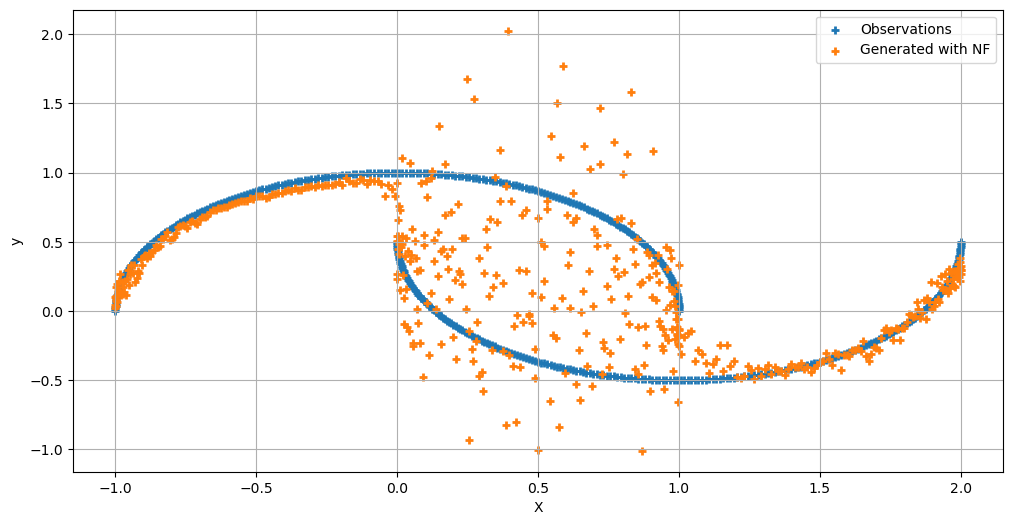

In [183]:
plt.figure(figsize=(12, 6))
# plt.plot(X, mu, label='Mean true', color='0', linewidth=2)
plt.scatter(X_moon, y_moon, marker='+', label='Observations', linewidth=2)
plt.scatter(X_moon, y_gen, marker='+', label='Generated with NF', color='C1', linewidth=2)
plt.xlabel("X")
plt.ylabel("y")
plt.grid()
plt.legend()
plt.show()